# Black-Scholes Deep Learning


In [1]:
%pylab inline
import pandas
pandas.set_option('display.float_format', lambda x: '%.3f' % x)

Populating the interactive namespace from numpy and matplotlib


## The Closed-Form Black-Scholes (1973) Option Pricing Model

In [2]:
from scipy.stats import norm
def BSM(S,K,T,sig,rf,dv,cp):  #cp = {+1.0 (calls), -1.0 (puts)}
    d1 = (math.log(S/K)+(rf-dv+0.5*sig**2)*T)/(sig*math.sqrt(T))
    d2 = d1 - sig*math.sqrt(T)
    return cp*S*math.exp(-dv*T)*norm.cdf(d1*cp) - cp*K*math.exp(-rf*T)*norm.cdf(d2*cp)

#Exemplo PETR4 || PUT || Strike 26.72 || Spot 15.95 || Taxa de Juros 3.4998% || Dividendos 0.1% || Sigma 0.72
S = 52.93
K = 39.68
T = 65/252 #anos
r = 0.050105 #taxa de juros anualizada
q = 0.003258 #dividendos
sigma = 1.36 #volatilidade 20%
BSM(S, K, T,sigma, r, q, 1)

20.393886529096537

# Gerando os dados aleatorios

In [3]:
from math import sqrt, exp, log, erf
import numpy as np
import pandas as pd 

#   Generate data samples
#   We resolve dependent parameters strike and underlying price to ratio strike/underlying
class DataGenerator():

    def generate_random_input(self, n):
        spot = np.random.uniform(1, 150, n)
        strike = np.random.uniform(1, 200, n) # K/S
        time = (np.random.randint(1, 90, n))                      # time until expiration in days
        rate = np.random.uniform(0.0375, 0.06, n)                   # Annualized risk free rate
        sigma = np.random.uniform(0.1, 2.0, n)                # Standard Deviation of stock's returns
        dividend = np.random.uniform(0.01, 0.06, n)                # Dividend yield
        return np.matrix([spot,strike, time, rate, sigma, dividend]).transpose()

    def calc_black_scholes(self, x):
        # shorthanded
        ratio_strike_underlying = x[0]
        time = x[1]
        rate = x[2]
        sigma = x[3]
        dividend = x[4]
        
        sigTsquared = sqrt(time / 365) * sigma
        edivT = exp((-dividend * time) / 365)
        ert = exp((-rate * time) / 365)
        d1 = (log(edivT/ratio_strike_underlying) + (rate + .5 * (sigma ** 2)) * time / 365) / sigTsquared
        d2 = d1 - sigTsquared
        Nd1 = (1 + erf(d1 / sqrt(2))) / 2
        Nd2 = (1 + erf(d2 / sqrt(2))) / 2

        # We are only interested in ratio of premium to underlying price
        ratio_call_premium_underlying = edivT*Nd1 - ratio_strike_underlying * ert * Nd2

        return ratio_call_premium_underlying

    def generate_output(self, input_data):
        return np.apply_along_axis(self.calc_black_scholes, axis=1, arr=input_data)

    


In [4]:
n_samples = 300000
tdg = DataGenerator()
X = tdg.generate_random_input(n_samples) 
dados = pd.DataFrame(data=X, columns=['Stock Price','Strike Price', 'Maturity', 'Risk-free', 'Volatility', 'Dividends'])

dados['DU'] = dados['Maturity']

dados['Maturity'] = dados['Maturity']/252



#cria nova coluna a partir dos valores gerados
def call_premio (row):
   return BSM(row['Stock Price'],row['Strike Price'],row['Maturity'],row['Volatility'],row['Risk-free'],row['Dividends'],1)



dados['Call Price'] = dados.apply (lambda row: call_premio(row), axis=1)

dados.to_csv("training.csv",index=True)

dados


,Stock Price,Strike Price,Maturity,Risk-free,Volatility,Dividends,DU,Call Price
0,36.165,71.534,0.012,0.054,0.518,0.035,3.000,0.000
1,81.382,118.366,0.175,0.049,0.837,0.037,44.000,2.477
2,12.039,128.187,0.024,0.053,1.999,0.015,6.000,0.000
3,58.023,105.710,0.298,0.059,0.551,0.011,75.000,0.226
4,47.150,199.279,0.325,0.053,1.882,0.059,82.000,3.823
5,101.679,150.483,0.190,0.042,0.707,0.059,48.000,1.777
6,97.930,70.769,0.341,0.049,1.223,0.030,86.000,39.219
7,58.049,10.857,0.298,0.041,0.810,0.018,75.000,47.006
8,97.712,58.252,0.179,0.052,1.771,0.043,45.000,47.039
9,97.791,84.756,0.004,0.051,1.312,0.059,1.000,13.157


## Read in data

In [5]:
df = pandas.read_csv('training.csv')
df

,Unnamed: 0,Stock Price,Strike Price,Maturity,Risk-free,Volatility,Dividends,DU,Call Price
0,0,36.165,71.534,0.012,0.054,0.518,0.035,3.000,0.000
1,1,81.382,118.366,0.175,0.049,0.837,0.037,44.000,2.477
2,2,12.039,128.187,0.024,0.053,1.999,0.015,6.000,0.000
3,3,58.023,105.710,0.298,0.059,0.551,0.011,75.000,0.226
4,4,47.150,199.279,0.325,0.053,1.882,0.059,82.000,3.823
5,5,101.679,150.483,0.190,0.042,0.707,0.059,48.000,1.777
6,6,97.930,70.769,0.341,0.049,1.223,0.030,86.000,39.219
7,7,58.049,10.857,0.298,0.041,0.810,0.018,75.000,47.006
8,8,97.712,58.252,0.179,0.052,1.771,0.043,45.000,47.039
9,9,97.791,84.756,0.004,0.051,1.312,0.059,1.000,13.157


## Normalizing spot and call prices
$C$ is homogeneous degree one, so
$$ aC(S,K) = C(aS,aK) $$
This means we can normalize spot and call prices and remove  a variable by dividing by $K$.
$$ \frac{C(S,K)}{K} = C(S/K,1) $$

In [6]:
df['Stock Price'] = df['Stock Price']/df['Strike Price']
df['Call Price']  = df['Call Price'] /df['Strike Price']

## Partition data into training and testing sets

In [7]:
n = len(df)
n_train =  (int)(0.8 * n)

In [8]:
train = df[0:n_train]
X_train = train[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_train = train['Call Price'].values

In [9]:
y_train

array([2.54072489e-036, 2.09306044e-002, 1.03906634e-016, ...,
       6.73727497e-001, 7.44458079e-156, 3.96986622e-001])

In [10]:
test = df[n_train+1:n]
X_test = test[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_test = test['Call Price'].values
len(test)

59999

## Import libraries

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import tensorflow as tf

Using TensorFlow backend.


## Define custom activation function
The exponential is used because it returns positive-only values

In [12]:
def custom_activation(x):
    return backend.exp(x)

## Arquitetura 1

In [13]:
np.random.seed(0) 
tf.set_random_seed(0)

nodes = 120
model1 = Sequential()

model1.add(Dense(nodes, input_dim=X_train.shape[1]))
model1.add(LeakyReLU())
model1.add(Dropout(0.25))

model1.add(Dense(nodes, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(nodes, activation='relu'))
model1.add(Dropout(0.25))

#model1.add(Dense(nodes, activation='relu'))
#model1.add(Dropout(0.25))

model1.add(Dense(1,activation='relu'))
#model.add(Activation(custom_activation))
          
model1.compile(loss='mse',optimizer='rmsprop')
from ann_visualizer.visualize import ann_viz
#ann_viz(model1,title="model1")

Instructions for updating:
Colocations handled automatically by placer.


# Arquitetura 2

In [14]:
nodes = 120
model2 = Sequential()

model2.add(Dense(nodes, input_dim=X_train.shape[1]))

model2.add(LeakyReLU())
model2.add(Dropout(0.25))
model2.add(Dense(1))
#model.add(Activation(custom_activation))

          
model2.compile(loss='mse',optimizer='rmsprop')
from ann_visualizer.visualize import ann_viz
#ann_viz(model2,title="model2")

# Arquitetura 3


In [15]:
nodes = 120
model3 = Sequential()

model3.add(Dense(nodes, input_dim=X_train.shape[1]))
model3.add(LeakyReLU())
model3.add(Dropout(0.25))

model3.add(Dense(60, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(nodes, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(60, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(1))
#model.add(Activation(custom_activation))
          
model3.compile(loss='mse',optimizer='rmsprop')
from ann_visualizer.visualize import ann_viz
#ann_viz(model3,title="model3")

In [16]:
model1.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)
model2.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)
model3.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 9s - loss: 0.9489 - val_loss: 0.1239
Epoch 2/10
 - 8s - loss: 0.7711 - val_loss: 0.5028
Epoch 3/10
 - 9s - loss: 0.7076 - val_loss: 0.0163
Epoch 4/10
 - 8s - loss: 0.6643 - val_loss: 0.0087
Epoch 5/10
 - 8s - loss: 0.6190 - val_loss: 0.1096
Epoch 6/10
 - 8s - loss: 0.6164 - val_loss: 0.0136
Epoch 7/10
 - 8s - loss: 0.6117 - val_loss: 0.3049
Epoch 8/10
 - 8s - loss: 0.6112 - val_loss: 0.0098
Epoch 9/10
 - 9s - loss: 0.5737 - val_loss: 0.0793
Epoch 10/10
 - 8s - loss: 0.5798 - val_loss: 0.0950
Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 4s - loss: 0.3292 - val_loss: 0.0124
Epoch 2/10
 - 4s - loss: 0.1531 - val_loss: 0.0128
Epoch 3/10
 - 4s - loss: 0.1369 - val_loss: 0.0518
Epoch 4/10
 - 4s - loss: 0.1448 - val_loss: 0.0151
Epoch 5/10
 - 4s - loss: 0.1420 - val_loss: 0.1070
Epoch 6/10
 - 4s - loss: 0.1372 - val_loss: 0.0248
Epoch 7/10
 - 4s - loss: 0.1396 -

In [17]:
#model.save("BSNN.h5")

In [18]:
#from keras.models import load_model
#model = load_model("BSNN.h5")


In [19]:
#from ann_visualizer.visualize import ann_viz
#ann_viz(model,title="teste")

## Define method for checking and visualizing accuracy of predictions

In [35]:
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print ("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print ("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print ("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print ("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=100,edgecolor='black',color='white',density = True,range=(-1,1))
    plt.xlabel('Diferença')
    plt.ylabel('Densidade')
    plt.show()
    
    return stats





## Check accuracy of predictions (In-Sample)

Mean Squared Error:       0.1032737129016985
Root Mean Squared Error:  0.3213622767247246
Mean Absolute Error:      0.13170961659413918
Mean Percent Error:       0.23246997300043482


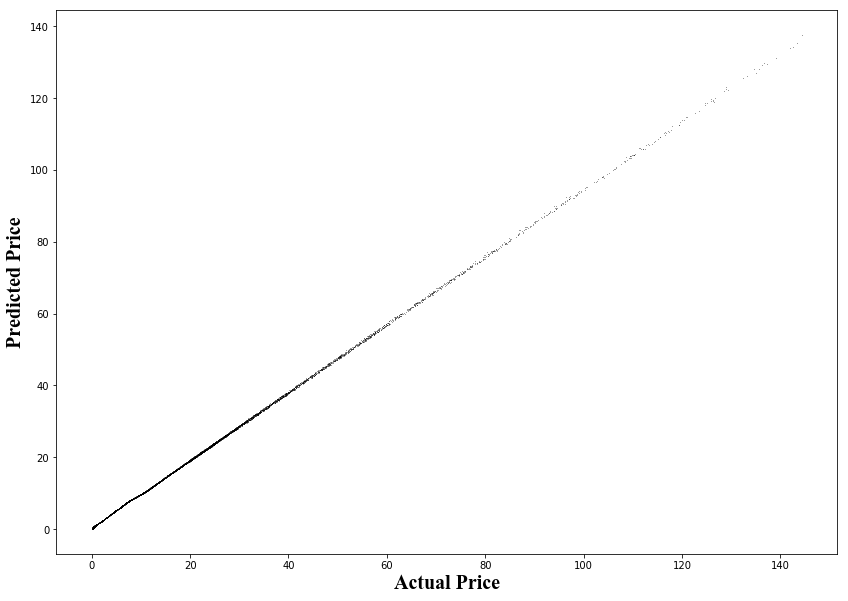

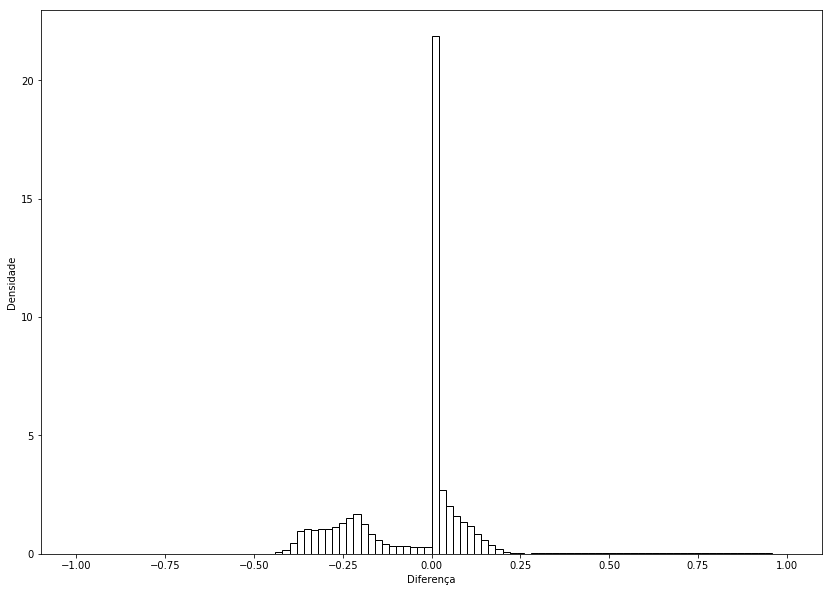

{'diff': array([ 2.54072489e-036,  2.09306044e-002,  1.03906634e-016, ...,
        -3.95556585e-001,  7.44458079e-156, -1.00963217e-001]),
 'mse': 0.1032737129016985,
 'rmse': 0.3213622767247246,
 'mae': 0.13170961659413918,
 'mpe': 0.23246997300043482}

In [36]:
#t_traint_hat1 e o resultado do modelo aplicado a amostra de treino
y_train_hat1 = model1.predict(X_train)

y_train_hat1 = squeeze(y_train_hat1)
CheckAccuracy(y_train, y_train_hat1)

Mean Squared Error:       0.01608452325591751
Root Mean Squared Error:  0.1268247738256115
Mean Absolute Error:      0.09743644298718883
Mean Percent Error:       0.0917436609159977


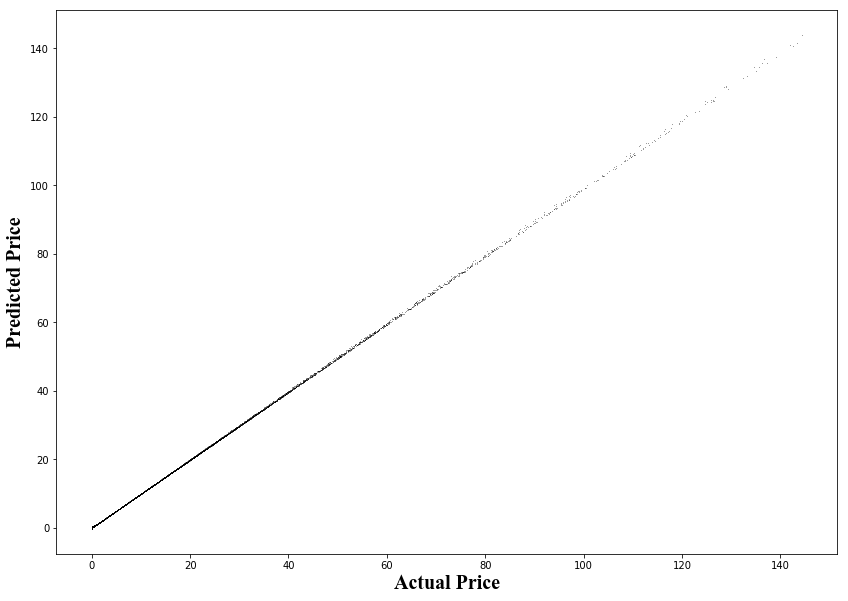

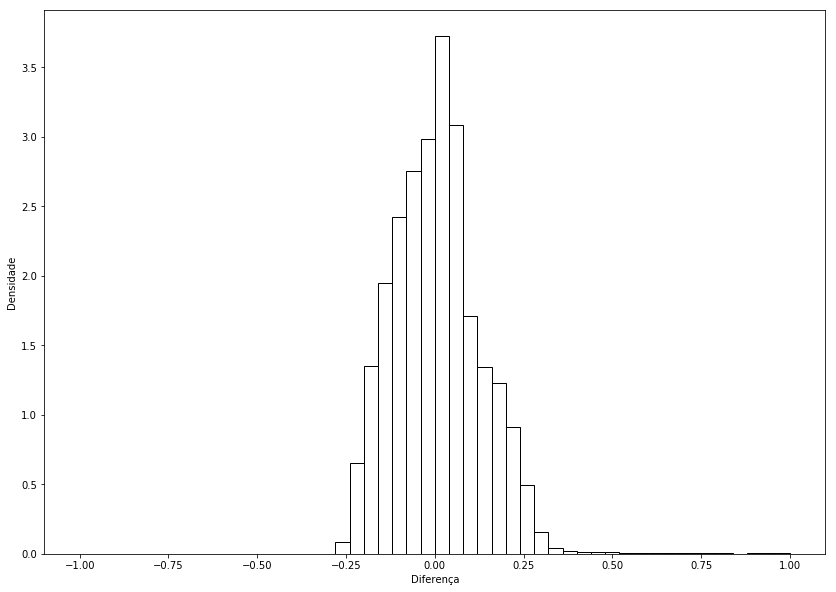

{'diff': array([ 0.0307541 , -0.10530543,  0.17834376, ..., -0.05959828,
         0.22552629,  0.02073504]),
 'mse': 0.01608452325591751,
 'rmse': 0.1268247738256115,
 'mae': 0.09743644298718883,
 'mpe': 0.0917436609159977}

In [22]:
y_train_hat2 = model2.predict(X_train)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat2 = squeeze(y_train_hat2)
CheckAccuracy(y_train, y_train_hat2)

Mean Squared Error:       2.4361740287832276
Root Mean Squared Error:  1.5608247911867712
Mean Absolute Error:      0.2775959184193535
Mean Percent Error:       1.12908366459081


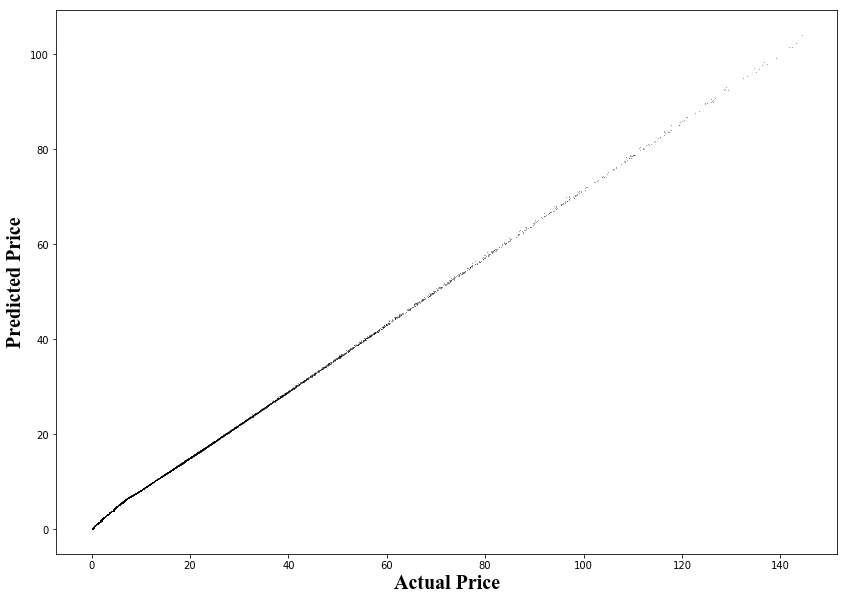

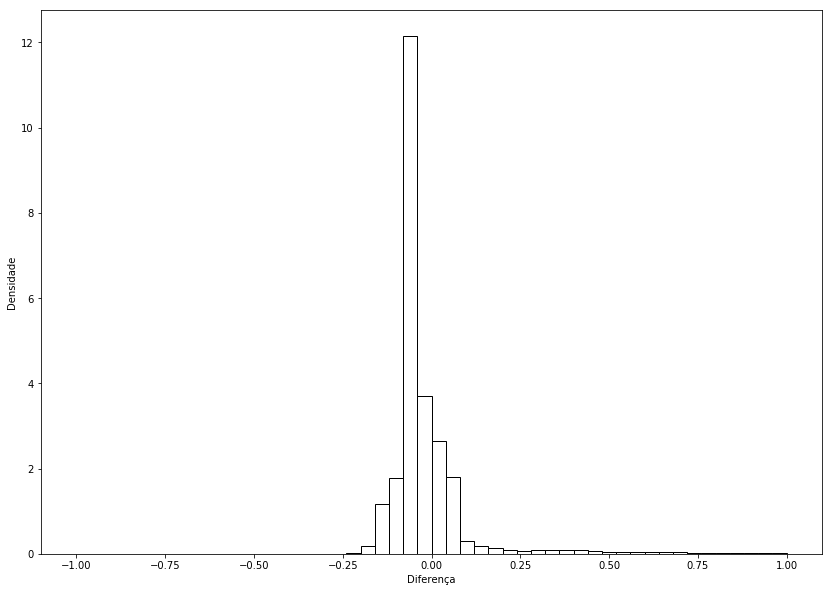

{'diff': array([-0.05077612, -0.03629522, -0.04860628, ..., -0.149327  ,
        -0.0449667 , -0.11368177]),
 'mse': 2.4361740287832276,
 'rmse': 1.5608247911867712,
 'mae': 0.2775959184193535,
 'mpe': 1.12908366459081}

In [23]:
y_train_hat3 = model3.predict(X_train)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat3 = squeeze(y_train_hat3)
CheckAccuracy(y_train, y_train_hat3)

## Check accuracy of predictions (Validation)

In [24]:
y_test_hat1 = model1.predict(X_test)
y_test_hat2 = model2.predict(X_test)
y_test_hat3 = model3.predict(X_test)

In [25]:
#reduce dim (240000,1) -> (240000,) to match y_test's dim 
y_test_hat1 = squeeze(y_test_hat1)
y_test_hat2 = squeeze(y_test_hat2)
y_test_hat3 = squeeze(y_test_hat3)

Mean Squared Error:       0.10889560058385687
Root Mean Squared Error:  0.3299933341506414
Mean Absolute Error:      0.13146893268068846
Mean Percent Error:       0.2403060568101672


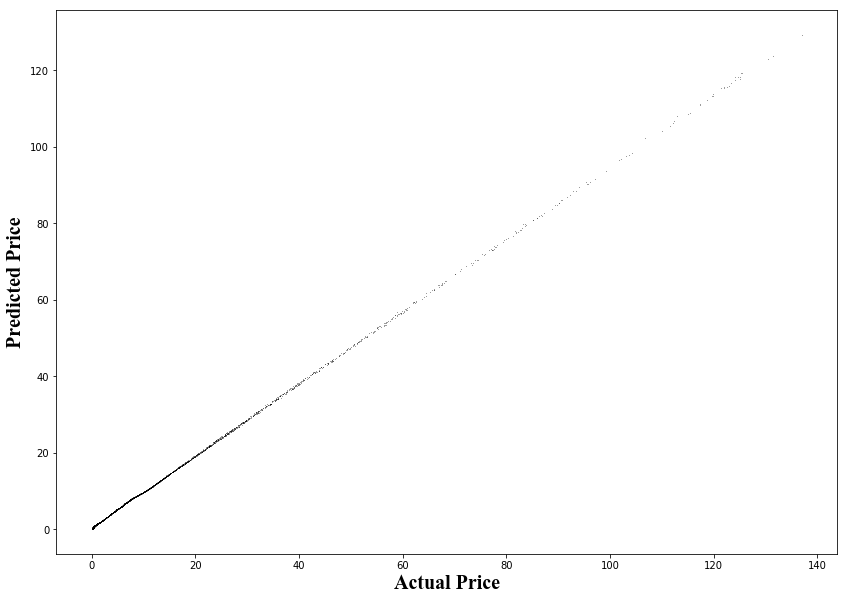

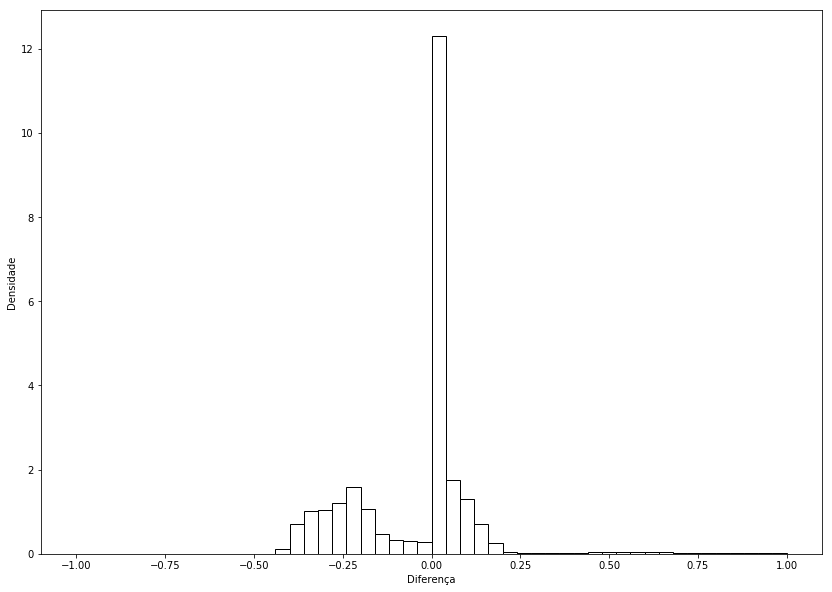

In [26]:
#y_test_hat1 = model1.predict(X_test)
test_stats1 = CheckAccuracy(y_test, y_test_hat1)

Mean Squared Error:       0.016175888806934966
Root Mean Squared Error:  0.127184467632392
Mean Absolute Error:      0.09714408811786585
Mean Percent Error:       0.09261762205865774


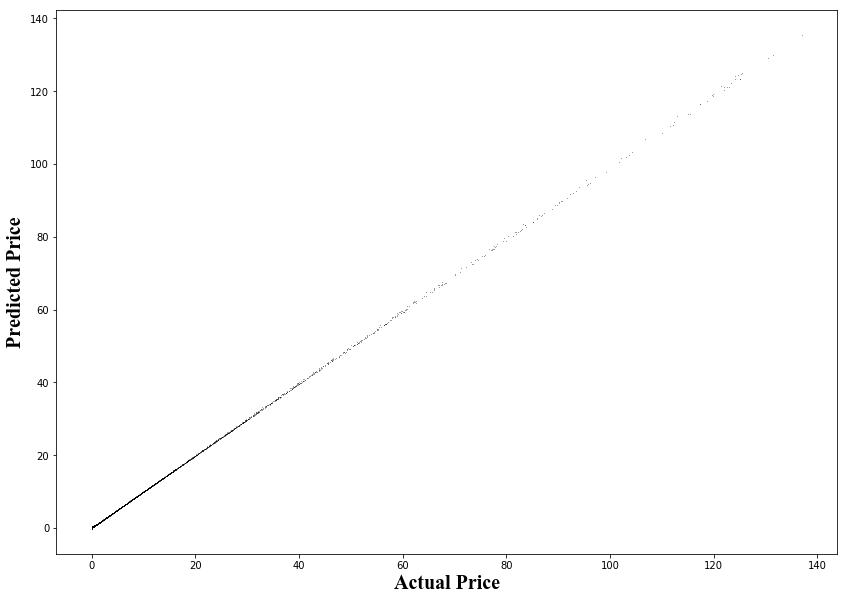

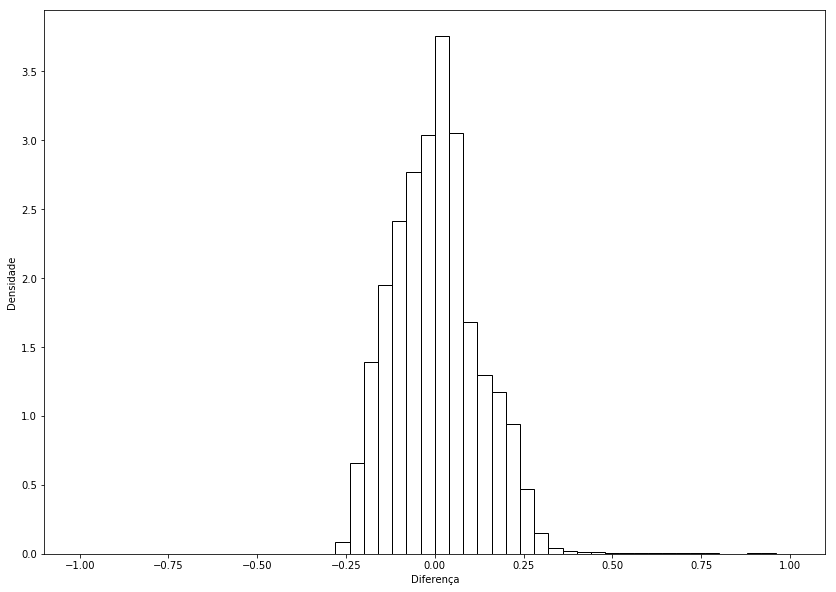

In [27]:
test_stats2 = CheckAccuracy(y_test, y_test_hat2)


Mean Squared Error:       2.606403672077391
Root Mean Squared Error:  1.6144360229124568
Mean Absolute Error:      0.27689553175086873
Mean Percent Error:       1.1756563375346203


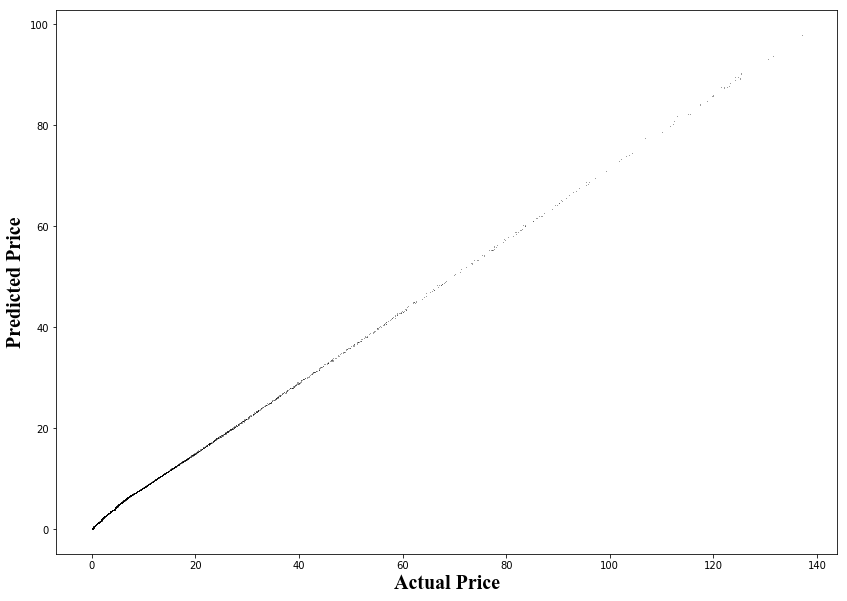

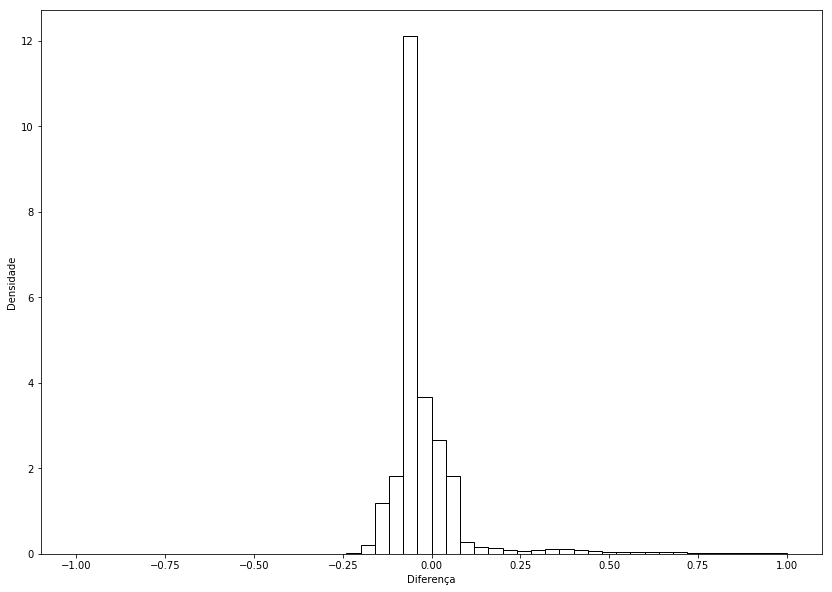

In [28]:
test_stats3 = CheckAccuracy(y_test, y_test_hat3)

In [29]:
stats = []
stats = y_train - y_train_hat2
max(stats)

1.8663770355863107

## Plot absolute error by option price size (moneyness)

NameError: name 'test_stats' is not defined

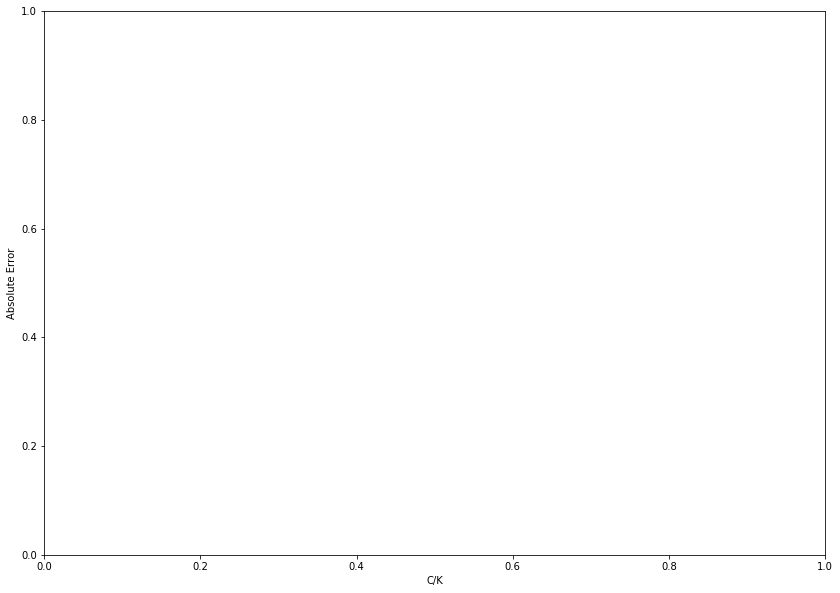

In [30]:
figure(figsize=(14,10))
plt.ylabel('Absolute Error')
plt.xlabel('C/K')
plt.scatter(y_test ,abs(test_stats['diff']), alpha=0.4, s=0.5,color='black');

## Plot percentage error by option price size (moneyness)

In [ ]:
figure(figsize=(14,10))
plt.ylabel('Absolute Percent Error',fontsize=20,fontname='Times New Roman')
plt.xlabel('Call Price/Strike Price',fontsize=20,fontname='Times New Roman')
plt.scatter(y_test ,abs(test_stats['diff']/y_test_hat1), alpha=0.4, s=0.5,color='black');

## Use the builtin Keras 'evaluate' function

In [ ]:
model1.evaluate(X_test, y_test, batch_size=32, verbose=2)

In [ ]:
model2.evaluate(X_test, y_test, batch_size=32, verbose=2)

In [ ]:
model3.evaluate(X_test, y_test, batch_size=32, verbose=2)

## Check against the closed BSM form

In [ ]:
S=92.92801
K=86.404477
T=0.071429 
dv=0.005264
sig=0.294957
rf=0.054175


In [ ]:
BSM(S,K,T,sig,rf,dv,1)

In [ ]:
X_check = np.array((S/K,T,dv,sig,rf))
X_check = X_check[None,:]

print (model3.predict(X_check))

## Compare to a Random Forest of decision trees

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)
y_test_hat = forest.predict(X_test)

CheckAccuracy(y_test, y_test_hat)